In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train=pd.read_csv('/content/drive/My Drive/Tenx/Week 5/train_processed.csv')
test=pd.read_csv('/content/drive/My Drive/Tenx/Week 5/test_processed.csv')

In [3]:
test.shape

(14816, 27)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59035 entries, 0 to 59034
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionId            59035 non-null  object 
 1   BatchId                  59035 non-null  object 
 2   AccountId                59035 non-null  object 
 3   SubscriptionId           59035 non-null  object 
 4   CustomerId               59035 non-null  object 
 5   CurrencyCode             59035 non-null  object 
 6   CountryCode              59035 non-null  int64  
 7   ProviderId               59035 non-null  object 
 8   ProductId                59035 non-null  object 
 9   ProductCategory          59035 non-null  object 
 10  ChannelId                59035 non-null  object 
 11  Amount                   59035 non-null  float64
 12  Value                    59035 non-null  float64
 13  TransactionStartTime     59035 non-null  object 
 14  PricingStrategy       

# 1. Model Selection and Training

In [6]:
# Import Script
import ML
import importlib
importlib.reload(ML)

<module 'ML' from '/content/ML.py'>

Add WOE and IV

In [7]:
pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=356cf2147afaca08cabc6b5cf677533bcd6688874bee1455adb409f450910588
  Stored in directory: /root/.cache/pip/wheels/68/88/65/58d6aa058698c47d7a24352952ea07a1409cc2eff3a8087c0c
Successfully built scorecardpy


In [8]:
train['is_high_risk'].unique()

array([0., 1.])

In [9]:
import scorecardpy as sc
train_var=train[['Amount','PricingStrategy','FraudResult','Total','Average','ProductCategory_encoded','ChannelId_encoded','is_high_risk']]
train_var['is_high_risk'] = train_var['is_high_risk'].astype(int)
bins = sc.woebin(train_var,y='is_high_risk')

/tmp/ipython-input-9-223515311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_var['is_high_risk'] = train_var['is_high_risk'].astype(int)


[INFO] creating woe binning ...


/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.11/dist-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

Binning on 59035 rows and 8 columns in 00:00:24


In [10]:
train_woe = sc.woebin_ply(train_var, bins)

[INFO] converting into woe values ...


In [11]:
#Prepare test data
test_var=test[['Amount','PricingStrategy','FraudResult','Total','Average','ProductCategory_encoded','ChannelId_encoded','is_high_risk']]
test_var['is_high_risk'] = test_var['is_high_risk'].astype(int)
test_woe=sc.woebin_ply(test_var, bins)


/tmp/ipython-input-11-1822940561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_var['is_high_risk'] = test_var['is_high_risk'].astype(int)


[INFO] converting into woe values ...


In [12]:
train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59035 entries, 0 to 59034
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_high_risk                 59035 non-null  int64  
 1   Average_woe                  59035 non-null  float64
 2   ChannelId_encoded_woe        59035 non-null  float64
 3   Amount_woe                   59035 non-null  float64
 4   Total_woe                    59035 non-null  float64
 5   FraudResult_woe              59035 non-null  float64
 6   ProductCategory_encoded_woe  59035 non-null  float64
 7   PricingStrategy_woe          59035 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.6 MB


In [13]:
iv_values = {k: v['total_iv'].values[0] for k, v in bins.items()}
print(iv_values)

{'Average': np.float64(0.17711757139873022), 'ChannelId_encoded': np.float64(0.0009966410134348534), 'Amount': np.float64(0.04041046000187761), 'Total': np.float64(1.3320350475987603), 'FraudResult': np.float64(0.0), 'ProductCategory_encoded': np.float64(0.006725242699282664), 'PricingStrategy': np.float64(0.006474835850555724)}


**Choose Models : Logistic Regression**

In [14]:
x_train=train_woe.drop('is_high_risk',axis=1)

In [15]:
y_train=train_woe['is_high_risk']

In [16]:
x_test=test_woe.drop('is_high_risk',axis=1)
y_test=test_woe['is_high_risk']

In [17]:
# Linear regression
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(penalty='l1', C=0.01, solver='liblinear',class_weight='balanced')
logreg.fit(x_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [18]:
train_pred = logreg.predict(x_train)
test_pred = logreg.predict(x_test)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],}

grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7577369357161005


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],}

grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='recall')
grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.76281057227652


In [21]:
#Accuracy for train
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, train_pred)
accuracy

0.7382061488947235

In [22]:
#Accuracy for test
from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, test_pred)
accuracy2

0.880939524838013

In [23]:
#recall for test
from sklearn.metrics import recall_score
recall = recall_score(y_test, test_pred)
recall

0.03480278422273782

Choose Models : Gradient Boosting

In [24]:
!pip install xgboost

In [25]:
#XGBoost
import xgboost
xgb_clf = xgboost.XGBClassifier(eval_metric='logloss', random_state=42,n_jobs=-1,learning_rate= 0.2, max_depth= 5, n_estimators= 100, subsample= 0.8)
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [26]:
train_pred = xgb_clf.predict(x_train)
test_pred = xgb_clf.predict(x_test)

In [27]:
#Accuracy for train
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, train_pred)
accuracy

0.8849834843736767

In [28]:
#Accuracy for test
from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, test_pred)
accuracy2

0.8833018358531317

In [29]:
#recall for test
from sklearn.metrics import recall_score
recall = recall_score(y_test, test_pred)
recall

0.0069605568445475635

0.5028310269710059


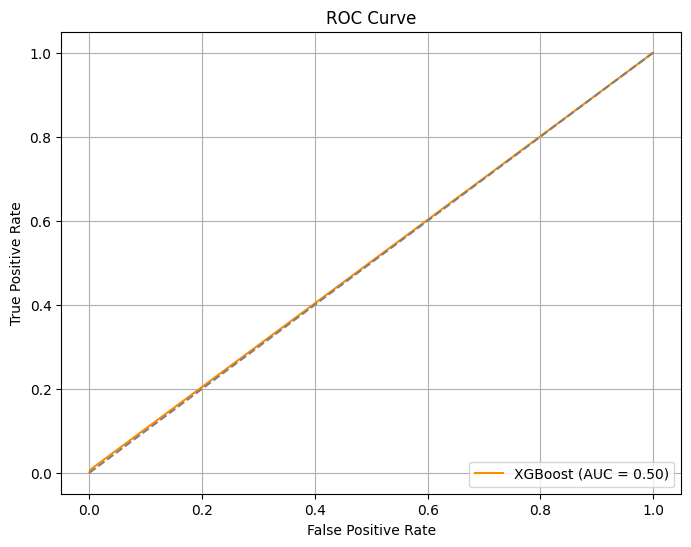

In [31]:
# Calculate ROC AUC score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, test_pred)
print(roc_auc)


fpr, tpr, thresholds = roc_curve(y_test,test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Grid search setup
param_grid = {'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
best_model = grid_search.best_estimator_

# Predict with best model
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.8833018358531317
Precision: 0.41379310344827586
Recall: 0.0069605568445475635
ROC AUC: 0.7324978795431653


In [34]:
#Set up MLflow
!pip install mlflow
import mlflow
import mlflow.sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 15.2 MB/s eta 0:00:00


In [37]:
# Start MLflow run
with mlflow.start_run() as run:
    # Log model (can also log metrics, params)
    mlflow.sklearn.log_model(
        sk_model=xgb_clf,
        artifact_path="model",
        registered_model_name="BestClassifierModel" )

    # Optional: log accuracy or other metrics
    acc = xgb_clf.score(x_test, y_test)
    mlflow.log_metric("accuracy", acc)

2025/07/03 20:08:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 20:09:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'BestClassifierModel' already exists. Creating a new version of this model...
Created version '2' of model 'BestClassifierModel'.


In [38]:
!zip -r mlruns.zip /content/mlruns

  adding: content/mlruns/ (stored 0%)
  adding: content/mlruns/0/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/params/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/metrics/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/tags/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/tags/mlflow.source.type (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/tags/mlflow.user (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/tags/mlflow.source.name (deflated 5%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/tags/mlflow.runName (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/artifacts/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/outputs/ (stored 0%)
  adding: content/mlruns/0/7b3b19f98fc749f5a57b5e0f62bf248b/outputs/m-2

In [39]:
from google.colab import files
files.download("mlruns.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>